# Setup

## Librerías, modulos y configuración de la notebook 

In [1]:
#### Librerías y modulos ####
import pandas as pd
import numpy as np
import seaborn as sns
import os,json
import matplotlib.pyplot as plt
import sklearn
from pandas.io import gbq
from datetime import datetime
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import sys
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()),'src/'))
from funcs_cotizador import *

In [2]:
#### Configuraciones de la notebook ####
#pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
#pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [3]:
#### Parametros de la notebook ####
path_save = '../datos/'
# actualizado al 04/19
dolar_blue = 197
dolar_oficial = 119.28

## Load data

In [4]:
# Upload del pickle generado en la notebook "make_data"
df = pd.read_pickle('{}df_meli_2022-04-19.pkl'.format(path_save))

In [5]:
df.shape

(822639, 42)

# Data Cleaning/Preprocessing 

### *Eliminar nulos*

In [6]:
old_shape = df.shape[0]
df = df.dropna(subset=['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','Subseg_a', 'Seg_a'])
print(f'Hey! {old_shape - df.shape[0]} were removed due to null values')
old_shape = df.shape[0]

Hey! 1011 were removed due to null values


### *Eliminar duplicados*

In [7]:
# Tratamiento de la feautre "runtime"
df['runtime'] = pd.to_datetime(df.runtime.apply(lambda x: str(x)[:19]))
df = df.sort_values(['runtime'])
# Ahora si, teniendo el df ordenado, eliminamos los duplicados, quedandonos con el registro más reciente (la última ocurrencia)
df.drop_duplicates(subset=['car_id'], keep='last', inplace=True)

In [8]:
df.shape

(128924, 42)

### *Eliminar 11111 & 999999*

**Dropeamos valores como 111111 o 999999 (ya sean outliers o no)** --> ESTO HAY QUE SUMARLO AL PROCESAMIENTO DE LAS SIMULACIONES !!! <br> 
* Pueden existir casos donde estos valores extraños no sean outliers, por lo tanto no los vamos a conseguir limpiar cuando dropiemos outliers. Es por eso que desarrollamos el siguiente metodo
* Es clave hacerlo en este momento sobre "price_amount" y no luego sobre "price_meli_ok" ya que hay casos en los que el price simbol es USD y luego cuando lo multiplicamos por el TC para pasar a "price_meli_ok" dejan de cumplir estas condiciones de ser 111111 o 999999 y les perdemos el rastro

In [9]:
df['price_amount'] = df.price_amount.astype('int')

In [10]:
m1 = df.price_amount == 1111
m2 = df.price_amount == 11111
m3 = df.price_amount == 111111
m4 = df.price_amount == 1111111
m5 = df.price_amount == 11111111
m6 = df.price_amount == 111111111

len(df[m1 | m2 | m3 | m4 | m5 | m6])

41

In [11]:
# observamos
df[m1 | m2 | m3 | m4 | m5 | m6][['price_amount']].head()

,price_amount
300430,11111111
257253,111111111
92823,1111111
20091,111111111
43836,111111111


In [12]:
df.shape

(128924, 42)

In [13]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5 | m6)]

In [14]:
df.shape

(128883, 42)

*Ahora lo mismo pero para los casos 999999*

In [15]:
m1 = df.price_amount == 9999
m2 = df.price_amount == 99999
m3 = df.price_amount == 999999
m4 = df.price_amount == 9999999
m5 = df.price_amount == 99999999

len(df[m1 | m2 | m3 | m4 | m5])

86

In [16]:
# observamos
df[m1 | m2 | m3 | m4 | m5 | m6][['price_amount']].head()

,price_amount
80396,9999999
94491,999999
33537,999999
22148,9999999
43903,9999999


In [17]:
df.shape

(128883, 42)

In [18]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5)]

In [19]:
df.shape

(128797, 42)

*Ahora lo mismo para kms*

In [20]:
df['car_kms'] = df.car_kms.astype('int')

In [21]:
df[df.car_kms > 0]['car_kms'].min()

1

In [22]:
m1 = df.car_kms == 1
m2 = df.car_kms == 11
m3 = df.car_kms == 111
m4 = df.car_kms == 1111
m5 = df.car_kms == 11111
m6 = df.car_kms == 111111
m7 = df.car_kms == 1111111
m8 = df.car_kms == 11111111

len(df[ m1 | m2 | m3 | m4 | m5 | m6 | m7 | m8])

802

In [23]:
# observamos
df[m1 | m2 | m3 | m4 | m5 | m6 | m7 | m8][['car_kms']].head()

,car_kms
256450,11111
256454,111111
276328,1111
275485,1111
256254,111111


In [24]:
df.shape

(128797, 42)

In [25]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5 | m6 | m7 | m8)]

In [26]:
df.shape

(127995, 42)

*Lo mismo pero para los valores 99999*

In [27]:
m1 = df.car_kms == 999
m2 = df.car_kms == 9999
m3 = df.car_kms == 99999
m4 = df.car_kms == 999999
m5 = df.car_kms == 9999999

len(df[m1 | m2 | m3 | m4 | m5])

77

In [28]:
# observamos
df[m1 | m2 | m3 | m4 | m5][['car_kms']].head()

,car_kms
297323,99999
296805,999
7306,999999
71130,999999
81555,999999


In [29]:
df.shape

(127995, 42)

In [30]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5)]

In [31]:
df.shape

(127918, 42)

In [32]:
# checkpoint
df.to_csv('{}df_checkpoint_1.pkl'.format(path_save))

In [33]:
df = pd.read_csv('{}df_checkpoint_1.pkl'.format(path_save))
df.shape

(127918, 43)

### *Precio final*

In [34]:
#Dropeamos los precios en dolares** --> Al final no lo hicimos
#Representan un 14% de la base !!! Caía mucho el test sin estos casos
# # observamos su volumen
# mask = df.price_symbol == 'U$S'
# display(df[mask].shape)
# display(round(df[mask].shape[0]/len(df),2))
# # dropeamos
# df.drop(list(df[mask].index),axis=0,inplace=True)
# display(df.shape)

In [35]:
# Construcción del precio final
blue= dolar_blue
oficial= dolar_oficial
col1 = 'price_symbol'
col2 = 'car_kms'
conditions = [df[col1]!='U$S', (df[col1]=='U$S') & (df[col2]==0), (df[col1]=='U$S') & (df[col2]!=0)]
choices = [df.price_amount, df['price_amount']*oficial, df['price_amount']*blue]

df['price_meli_ok'] = np.select(conditions, choices, default=np.nan)

### *Dropeamos 0kms y concesionaria*

In [36]:
df['dealer'] = np.where(df['dealer']==True,1,0)
mask_not_0km = df.car_kms > 90
mask_not_conces = df.dealer == 0

df = df[(mask_not_0km) & (mask_not_conces)]

In [37]:
df.shape

(57521, 44)

### *Dropeamos match_score por debajo de 50%*

In [38]:
lst = ['score_marca_a','score_modelo_a','score_v1_c']
for col in lst:
    df = df[df[col]>=80]
    
# chequeo
df[lst].min()

score_marca_a    92.00
score_modelo_a   86.00
score_v1_c       80.00
dtype: float64

In [39]:
df.shape

(45246, 44)

### *Dropeamos registros que no sean de los ultimos 15 días*

In [40]:
df.runtime.max()

'2022-04-18 23:01:25'

In [41]:
from datetime import date, datetime, timedelta

In [42]:
df['runtime'] = df['runtime'].apply(pd.to_datetime)

In [43]:
df[['runtime','price_meli_ok']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45246 entries, 2 to 127917
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   runtime        45246 non-null  datetime64[ns]
 1   price_meli_ok  45246 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 MB


In [44]:
max_date = df.runtime.max()
mask_last15d = (df.runtime <= max_date) & ((df.runtime >= max_date - timedelta(days=15)))
df = df[mask_last15d]

In [45]:
df.runtime.max()

Timestamp('2022-04-18 23:01:25')

In [46]:
print(df.runtime.min())
print(df.runtime.max())

2022-04-04 00:00:30
2022-04-18 23:01:25


In [47]:
df.shape

(42700, 44)

### *Tratamiento de outliers nº1*

*Vamos a eliminar solamente los outliers más absurdos antes de hacer el split*

In [48]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','match_v1_c', 'Subseg_a', 'Seg_a']
target = ['price_meli_ok']
id_features = ['runtime','car_id']

In [49]:
df.price_meli_ok.describe(percentiles=[0.005, 0.01,0.25,0.75,0.99,0.995,0.998,0.999])

count       42700.00
mean      2764265.77
std       3502660.56
min        100000.00
0.5%       600000.00
1%         670000.00
25%       1450000.00
50%       2150000.00
75%       3300000.00
99%      10200440.00
99.5%    12504797.50
99.8%    16778110.00
99.9%    23748360.00
max     236400000.00
Name: price_meli_ok, dtype: float64

In [50]:
# Asi como aca aparece esta Hilux, este tipo de casos los tratamos en el tratamiento de outliers nº2
df[df.price_meli_ok <= 250000][model_features]

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,match_v1_c,Subseg_a,Seg_a
20119,2021.00,960000,FIAT,Cronos,1.3 GSE MT Drive Pack Conectividad (99cv),DRIVE 1.3 MT,Gama Pequenos Sedan,Gama Pequenos
54359,2021.00,222222,NISSAN,Frontier,2.3D 6MT C/Doble 4x2 SE (190cv) (L18),CD SE 2.3 D 4X2 MT,Pickups Medianas-Grandes,Livianos
61003,2013.00,15000,RENAULT,Duster,2.0 4x4 6MT Luxe NAV (138cv),LUXE 2.0 4X4,Suv Compactas 4x2,SUV
87173,2007.00,10000,PEUGEOT,Boxer,350MH 2.8 HDI Larga Alta (L07),2.2,Furgon Mediano,Livianos
125640,2008.00,1500,VOLKSWAGEN,New Beetle,2.5 Sport,2.5 SPORT,Gama Medianos Sedan,Gama Medianos


In [51]:
df.shape

(42700, 44)

<AxesSubplot:xlabel='price_meli_ok'>

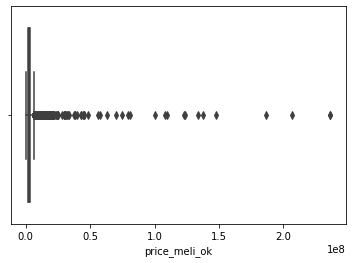

In [52]:
sns.boxplot(df.price_meli_ok)

In [53]:
# creamos diccionarios para guardar la info de capeo de outliers
thresh_outliers_1 = {}

In [54]:
# dropmeamos outliers globales de price
p_995 = df.price_meli_ok.quantile(0.995)
# guardamos la info de train para luego aplicarla en test
thresh_outliers_1['price_p995'] = p_995
mask = df.price_meli_ok <= p_995
df = df[mask]

<AxesSubplot:xlabel='price_meli_ok'>

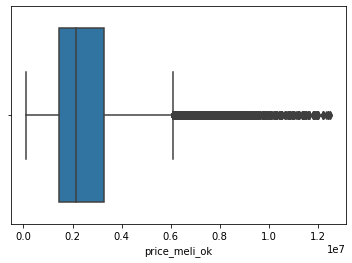

In [55]:
sns.boxplot(df.price_meli_ok)

In [56]:
df.price_meli_ok.describe(percentiles=[0.001,0.01,0.05,0.1,0.25,0.75,0.99])

count      42486.00
mean     2640980.23
std      1778961.77
min       100000.00
0.1%      484850.00
1%        670000.00
5%        850000.00
10%       980000.00
25%      1430000.00
50%      2150000.00
75%      3299999.75
99%      9000000.00
max     12500000.00
Name: price_meli_ok, dtype: float64

<AxesSubplot:xlabel='price_meli_ok', ylabel='Density'>

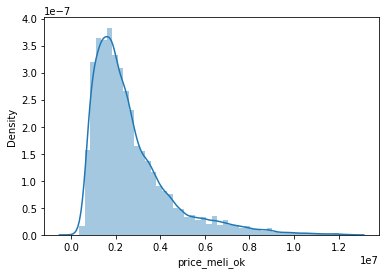

In [57]:
sns.distplot(df.price_meli_ok)

In [58]:
# Observamos los casos --> Podemos ver que hay casos como una Kangoo, KA, etc con precios absurdamente altos.
## Casos de este tipo trataremos en el tratamiento de outliers nº2
p_99 = df.price_meli_ok.quantile(0.99)
mask = df.price_meli_ok >= p_99
df[mask][model_features]

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,match_v1_c,Subseg_a,Seg_a
6459,2021.00,18000,TOYOTA,Hilux,3.0 TDI C/D 4x4 SRV AT Cuero (171cv),4X4,Pickups Medianas-Grandes,Livianos
6505,2021.00,25000,TOYOTA,Hilux,4x4 CD SRV 2.8 TDI 6AT Limited (177cv) (L16),4X4,Pickups Medianas-Grandes,Livianos
6506,2021.00,10000,TOYOTA,Hilux,4x4 CD SRX 2.8 TDI 6MT (177cv) (L16),4X4,Pickups Medianas-Grandes,Livianos
6507,2021.00,9000,TOYOTA,Hilux,4x4 CD SRX 2.8 TDI 6MT (177cv) (L16),4X4,Pickups Medianas-Grandes,Livianos
6509,2021.00,12000,TOYOTA,Hilux,4x4 CD SRX 2.8 TDI 6MT (177cv) (L16),4X4,Pickups Medianas-Grandes,Livianos
6510,2021.00,33000,TOYOTA,Hilux,4x4 CD SRV 2.8 TDI 6AT Limited (177cv) (L16),4X4,Pickups Medianas-Grandes,Livianos
6524,2021.00,910,TOYOTA,Hilux,4x4 CD SRX 2.8 TDI 6MT (177cv) (L16),4X4 D/C SRX 2.8 TDI 6 A/T,Pickups Medianas-Grandes,Livianos
6545,2020.00,1560,BMW,Serie 3,330i Sedán Sportive,2.2,SUV Premium,SUV
6546,2020.00,8500,BMW,Serie 3,330i Sedán Sportive,2.2,SUV Premium,SUV
6859,2017.00,19000,AUDI,TT,Coupé 2.0 TFSi S-Tronic (230cv) (L17),2.0 FSI,Premium,Premium


In [59]:
df.shape

(42486, 44)

*Ahora lo mismo pero para kms**

In [60]:
df.car_kms.describe(percentiles=[0.005, 0.01,0.25,0.75,0.99,0.995,0.998,0.999])

count      42486.00
mean      109888.18
std       106844.33
min          103.00
0.5%        1000.00
1%          3200.00
25%        60000.00
50%       100000.00
75%       147000.00
99%       302075.00
99.5%     350000.00
99.8%     421015.24
99.9%     535150.00
max     15000000.00
Name: car_kms, dtype: float64

<AxesSubplot:xlabel='car_kms'>

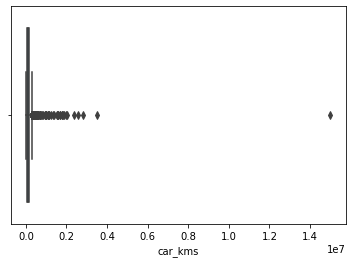

In [61]:
sns.boxplot(df.car_kms)

In [62]:
p_995 = df.car_kms.quantile(0.995)
# guardamos la info de train para luego aplicarla en test
thresh_outliers_1['kms_p995'] = p_995
mask = df.car_kms > p_995
len(df[mask])

205

In [63]:
# dropeamos outliers globales de car_kms
df = df[~mask]

In [64]:
# We are now able to save the dict with the information learned in the train set regarding the thresholds to cap outliers
import json
with open(f'{path_save}thresh_outliers_1.json', 'w') as fp:
    json.dump(thresh_outliers_1, fp)

<AxesSubplot:xlabel='car_kms'>

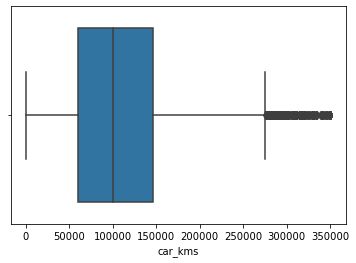

In [65]:
sns.boxplot(df.car_kms)

*Revision valores extremos o raros en car_year*

In [66]:
df.car_year.describe(percentiles=[0.005, 0.01,0.25,0.75,0.99,0.998,0.999])

count   42281.00
mean     2013.69
std         3.85
min      2006.00
0.5%     2006.00
1%       2006.00
25%      2011.00
50%      2014.00
75%      2017.00
99%      2021.00
99.8%    2021.00
99.9%    2021.00
max      2021.00
Name: car_year, dtype: float64

Vemos que no hay outliers ni casos raros en la variable de año

In [67]:
sorted(df.car_year.unique().tolist())

[2006.0,
 2007.0,
 2008.0,
 2009.0,
 2010.0,
 2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0,
 2017.0,
 2018.0,
 2019.0,
 2020.0,
 2021.0]

ATENCIÓN: No tenemos datos para 2008.

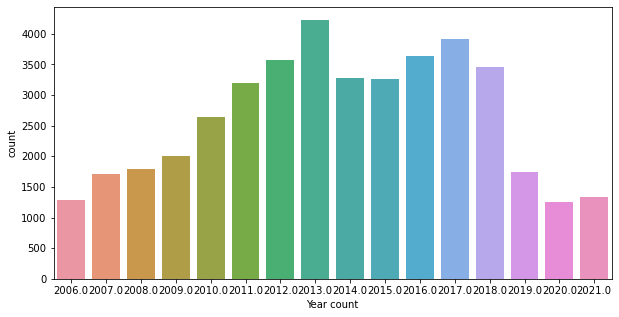

In [68]:
# plot distribution
fig = plt.figure(figsize = (10, 5))
sns.countplot(df.car_year)
plt.xlabel("Year count")
plt.show()

In [69]:
df['car_year'] = df['car_year'].astype('int')

*Data inconsistencies:*
* No tenemos datos de 2008
* La distribución es bastante simetrica y normal
* Tenemos un spike para los autos del 2013

***Fin del tratamiento de outliers nº1***

### *Dropeamos categorías que no nos sirven*

*Las categorías que dejamos afuera, son las que no nos interesa cotizar porque irán a reglas o al equipo de pricing*

Los grupos de los escenarios los vamos a re-definir aca. Debido a que cuando lo hicimos en la nb "Tres escenarios" como un primer apporach estaba bien y aparte el objetivo era validar la hipotesis de outliers vs presencia. Pero ocurre que aca el procesamiento es más profundo, y por lo tanto un auto que capas estaba en el grupo 4 en la nb "Tres Escenarios" aca debido a las limpiezas extra respesto a esa nb, pierden muchisimo volumen y quedaría en grupos muchísimos más bajos que no entrarían para el algoritmo. El caso perfecto es la F-150 de FORD: en ese caso en la nb "Tres Esce" quedaba en el grupo 4, y aca desp de todo el procesamiento nos queda 1 solo caso el cual se nos fue a test despues de split y en train no estaba, por lo tanto tira error la funcion de data_processing_1().

In [70]:
df_grouped = df.groupby(['match_marca_a','match_modelo_a','match_v1_a'],as_index=False).size()
df_grouped.columns = ['marca','modelo','version','cant']
df_grouped.sort_values(by='cant',ascending=False,inplace=True)

In [71]:
df_grouped.head(10)

,marca,modelo,version,cant
2020,VOLKSWAGEN,Gol Trend,1.6 MSI 5Ptas. Trendline (101cv) (L17),389
1394,PEUGEOT,308,Allure 1.6 HDI NAV (115cv) 5Ptas. (L16),386
1977,VOLKSWAGEN,Gol,1.6 3Ptas. Power,360
1603,RENAULT,Kangoo,1.6 Expression / Confort AA LV2 TRF 2ABG RACK ...,313
1340,PEUGEOT,208,1.6 N 16v Feline Tiptronic (115cv) (L18),278
1878,TOYOTA,Hilux,4x4 CD SRX 2.8 TDI 6MT (177cv) (L16),267
2008,VOLKSWAGEN,Gol Trend,1.6 3Ptas. Trendline / Pack I (101cv),262
825,FORD,Fiesta,1.6 Titanium Powershift (120cv) 5Ptas.,255
1821,TOYOTA,Corolla,XEI 1.8 CVT (140cv) (L18),253
1940,VOLKSWAGEN,Bora,2.0 Trendline MT,221


In [72]:
df_grouped.tail(10)

,marca,modelo,version,cant
1037,HYUNDAI,H1,Minibus 12 Pas. 2.5 TDI MT Full Plus (L08),1
1046,HYUNDAI,Sonata,3.3 V6 GLS AT,1
1833,TOYOTA,Corolla Cross,1.8 eCVT SEG LE,1
1051,HYUNDAI,Tucson,2.0 D GLS AT 4WD Full Premium (185cv) (L16),1
1060,HYUNDAI,Veloster,Sport 1.6T MT (204cv),1
1061,HYUNDAI,Veracruz,GLS 3.0 CRDI AT V6 7pas Full Premium,1
1062,HYUNDAI,Veracruz,GLS 3.8 N AT V6 7pas Full Premium,1
1064,JAC,S2,1.5 MT Intelligent (113cv) 5Ptas.,1
1066,JEEP,Cherokee,Sport 2.8 TD CRD AT (L08),1
0,ALFA ROMEO,147,1.9 JTD (150cv) 5Ptas.,1


In [73]:
mask = df_grouped['marca'] == 'VOLKSWAGEN'
df_grouped[mask].sort_values(by='modelo')

,marca,modelo,version,cant
1937,VOLKSWAGEN,Amarok,3.0 TDI V6 (258cv) 4x4 C/Doble Black Style AT ...,1
1925,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x4 C/Doble Comfortline (L17),12
1931,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x4 C/Doble Startline,2
1913,VOLKSWAGEN,Amarok,2.0 TDI (163cv) 4x4 C/Doble Startline,15
1923,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x2 C/Doble Ultimate AT,10
1905,VOLKSWAGEN,Amarok,2.0 TDI (140cv) 4x2 C/Simple Trendline (L17),10
1934,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x4 C/Doble Ultimate AT,9
1914,VOLKSWAGEN,Amarok,2.0 TDI (163cv) 4x4 C/Doble Trendline,16
1933,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x4 C/Doble Ultimate,3
1906,VOLKSWAGEN,Amarok,2.0 TDI (140cv) 4x4 C/Doble Trendline LL16'' C...,3


In [74]:
# agrupacion
df_grouped = df.groupby(['match_marca_a','match_modelo_a','match_v1_a'],as_index=False).size()
df_grouped.columns = ['marca','modelo','version','cant']
df_grouped.sort_values(by='cant',ascending=False,inplace=True)

# deciles
df_output = df_grouped.copy()

data = df_grouped.copy()
data.sort_values(by='cant',ascending=False,inplace=True)

data['cuantiles' + str('_'+'cant')] =pd.qcut(data['cant'], 10, duplicates='drop')

placeholder= 'marca'
tmp = data.groupby('cuantiles' + str('_'+'cant')).agg({placeholder:'count'}).rename(columns={placeholder:'placeholder'})
leni = len(tmp)
tmp['cuantil' + str('_'+'cant')] = list(reversed(list(np.arange(1,leni+1,1))))
tmp['bin' + str('_'+'cant')] = tmp.index
tmp.reset_index(drop=True,inplace=True)
tmp.drop('placeholder',1,inplace=True)

data = data.merge(tmp, how='inner',left_on=['cuantiles' + str('_'+'cant')], right_on='bin' + str('_'+'cant'))

#data.drop(cols_to_drop,1,inplace=True)

#df_output = df_output.merge(data, on=['marca','modelo','version'])

# seleccion y orden final de las columnas del output
#df_output_ok = df_output[['marca','modelo','version','cant','cuantil_cant','bin_cant']]
#df_output_ok.sort_values(by='cant',ascending=False,inplace=True)
#df_output_ok.head()

In [75]:
data.drop('cuantiles_cant',1,inplace=True)

In [76]:
asd = (data.groupby('cuantil_cant')['cant'].sum()/sum(data.cant))*100
asd

cuantil_cant
1   55.33
2   18.81
3    9.68
4    5.71
5    3.37
6    3.52
7    1.38
8    2.21
Name: cant, dtype: float64

In [77]:
tmp

,cuantil_cant,bin_cant
0,8,"(0.999, 2.0]"
1,7,"(2.0, 3.0]"
2,6,"(3.0, 6.0]"
3,5,"(6.0, 9.0]"
4,4,"(9.0, 14.0]"
5,3,"(14.0, 25.0]"
6,2,"(25.0, 53.0]"
7,1,"(53.0, 389.0]"


In [78]:
# Escenario de cotizacion: Algoritmo
print(f'Algoritmo: {asd.iloc[0:4].sum()}')
print(f'Reglas: {asd.iloc[4:7].sum()}')
print(f'Equipo Pricing: {asd.iloc[7:].sum()}')

Algoritmo: 89.51775028972824
Reglas: 8.268489392398477
Equipo Pricing: 2.2137603178732763


In [79]:
# Marcas-modelos en cada grupo
data['marca_modelo'] = data['marca'] + str(' - ') +data['modelo']
data.head()

,marca,modelo,version,cant,cuantil_cant,bin_cant,marca_modelo
0,VOLKSWAGEN,Gol Trend,1.6 MSI 5Ptas. Trendline (101cv) (L17),389,1,"(53.0, 389.0]",VOLKSWAGEN - Gol Trend
1,PEUGEOT,308,Allure 1.6 HDI NAV (115cv) 5Ptas. (L16),386,1,"(53.0, 389.0]",PEUGEOT - 308
2,VOLKSWAGEN,Gol,1.6 3Ptas. Power,360,1,"(53.0, 389.0]",VOLKSWAGEN - Gol
3,RENAULT,Kangoo,1.6 Expression / Confort AA LV2 TRF 2ABG RACK ...,313,1,"(53.0, 389.0]",RENAULT - Kangoo
4,PEUGEOT,208,1.6 N 16v Feline Tiptronic (115cv) (L18),278,1,"(53.0, 389.0]",PEUGEOT - 208


In [80]:
data[data.modelo == 'Tiggo']

,marca,modelo,version,cant,cuantil_cant,bin_cant,marca_modelo
144,CHERY,Tiggo,2.0 16v 4x2 Confort (138cv),73,1,"(53.0, 389.0]",CHERY - Tiggo
665,CHERY,Tiggo,2.0 16v 4x4 Luxury (138cv),14,4,"(9.0, 14.0]",CHERY - Tiggo
1312,CHERY,Tiggo,2.0 16v 4x2 Luxury AT (138cv),4,6,"(3.0, 6.0]",CHERY - Tiggo


In [81]:
# Marcas-modelos en cada grupo
sorted(list(data[data['cuantil_cant']==1]['marca_modelo'].unique()))

['AUDI - A1',
 'AUDI - A3',
 'AUDI - Q5',
 'BMW - Serie 3',
 'CHERY - Tiggo',
 'CHEVROLET - Agile',
 'CHEVROLET - Astra II',
 'CHEVROLET - Aveo',
 'CHEVROLET - Celta',
 'CHEVROLET - Classic',
 'CHEVROLET - Corsa II',
 'CHEVROLET - Cruze',
 'CHEVROLET - Meriva',
 'CHEVROLET - Onix',
 'CHEVROLET - Prisma',
 'CHEVROLET - S-10',
 'CHEVROLET - Tracker',
 'CHEVROLET - Zafira',
 'CITROEN - Berlingo',
 'CITROEN - C3',
 'CITROEN - C4',
 'CITROEN - C4 Lounge',
 'FIAT - 500',
 'FIAT - Cronos',
 'FIAT - Fiorino',
 'FIAT - Mobi',
 'FIAT - Palio',
 'FIAT - Punto',
 'FIAT - Siena',
 'FIAT - Strada',
 'FIAT - Toro',
 'FIAT - Uno',
 'FORD - EcoSport',
 'FORD - Fiesta',
 'FORD - Focus',
 'FORD - Focus III',
 'FORD - KA',
 'FORD - Ranger',
 'HONDA - CRV',
 'HONDA - Civic',
 'HONDA - Fit',
 'HONDA - HR-V',
 'JEEP - Compass',
 'JEEP - Renegade',
 'NISSAN - Kicks',
 'PEUGEOT - 2008',
 'PEUGEOT - 206',
 'PEUGEOT - 207',
 'PEUGEOT - 208',
 'PEUGEOT - 307',
 'PEUGEOT - 308',
 'PEUGEOT - 408',
 'PEUGEOT - Partn

In [82]:
grupos_df = data.copy()
# nos quedamos únicamente con los grupos que entran al modelo
grupos_df_algor = grupos_df[grupos_df['cuantil_cant'].apply(lambda x: x in [1,2,3])]
# check
grupos_df_algor.cuantil_cant.unique()

array([1, 2, 3])

In [83]:
# Nos quedamos unicamente con los marca-modelo-version dentro de los grupos 1, 2, 3 y 4
marcas_ok = list(grupos_df_algor.marca.unique())
modelos_ok = list(grupos_df_algor.modelo.unique())
versiones_ok = list(grupos_df_algor.version.unique())
# guardamos las marcas_ok y los modelos_ok ya que son los únicos que nos van a interesar scorear
pd.Series(marcas_ok).to_csv('{}marcas_ok.csv'.format(path_save))
pd.Series(modelos_ok).to_csv('{}modelos_ok.csv'.format(path_save))
pd.Series(versiones_ok).to_csv('{}versiones_ok.csv'.format(path_save))

mask1 = df.match_marca_a.apply(lambda x: x in marcas_ok)
mask2 = df.match_modelo_a.apply(lambda x: x in modelos_ok)
mask3 = df.match_v1_a.apply(lambda x: x in versiones_ok)

df = df[mask1 & mask2 & mask3]

In [84]:
sorted(list(df.match_marca_a.unique()))

['ALFA ROMEO',
 'AUDI',
 'BMW',
 'CHERY',
 'CHEVROLET',
 'CHRYSLER',
 'CITROEN',
 'DODGE',
 'DS',
 'FIAT',
 'FORD',
 'HONDA',
 'HYUNDAI',
 'JEEP',
 'KIA',
 'MERCEDES BENZ',
 'MINI',
 'MITSUBISHI',
 'NISSAN',
 'PEUGEOT',
 'RENAULT',
 'SUZUKI',
 'TOYOTA',
 'VOLKSWAGEN']

In [85]:
# cats_loc1_ok = ['Capital Federal','Bs.As. G.B.A. Sur','Bs.As. G.B.A. Norte'
#            ,'Bs.As. G.B.A. Oeste','Buenos Aires Interior','Bs.As. Costa Atlántica']
# mask1 = df.car_location_1.apply(lambda x: x in cats_loc1_ok)
# cats_brand_ok =['Alfa Romeo','Audi','BMW','Chery','Chevrolet','Citroën','DS','Fiat','Ford','Geely','Haval','Honda',
#  'Hyundai','JAC','Jeep','Kia','Land Rover','Lifan','Mercedes-Benz','Mini','Mitsubishi','Nissan','Peugeot','Porsche','RAM',
#  'Renault','SEAT','Shineray','Smart','Subaru','Suzuki','Toyota','Volkswagen','Volvo'] # Exclusion x pedido Edgar: Dodge, Chrysler
# mask2 = df.brand.apply(lambda x: x in cats_brand_ok)
# sub_mask = df.brand == 'Jeep'
# lst_not_renegade = [i for i in df[sub_mask]['match_modelo_a'].unique() if i != 'Renegade']
# mask3 = df.match_modelo_a.apply(lambda x: x not in lst_not_renegade)
# df = df[(mask1 & mask2 & mask3)]

In [86]:
df.shape

(35682, 44)

### Salvamos el dataset listo para el split

In [87]:
df.to_csv('{}df_checkpoint_2.pkl'.format(path_save))

In [88]:
df = pd.read_csv('{}df_checkpoint_2.pkl'.format(path_save))

In [89]:
df.shape

(35682, 45)

# Split

In [90]:
###### Split #######

X = df[model_features]
y = df.price_meli_ok

# 200 bines para discretizar la variable continua
bins = np.linspace(0, len(y), 200)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(y, bins)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,  stratify=y_binned,random_state=42)
print(X_train.shape, X_test.shape)

(28545, 8) (7137, 8)


In [91]:
# chequeamos distribuciones del target en ambos dfs
a = pd.concat([y_train.describe(percentiles=[0.001,0.01,0.1,0.25,0.5,0.75,0.9,0.99])
              ,y_test.describe(percentiles=[0.001,0.01,0.1,0.25,0.5,0.75,0.9,0.99])],axis=1)
a.columns = ['price_train','price_test']
a

,price_train,price_test
count,28545.00,7137.00
mean,2595766.85,2565076.82
std,1692463.01,1667954.76
min,210000.00,380000.00
0.1%,500000.00,511224.00
1%,700000.00,700000.00
10%,1000000.00,1000000.00
25%,1450000.00,1450000.00
50%,2100000.00,2100000.00
75%,3200000.00,3152000.00


<AxesSubplot:xlabel='price_meli_ok', ylabel='Density'>

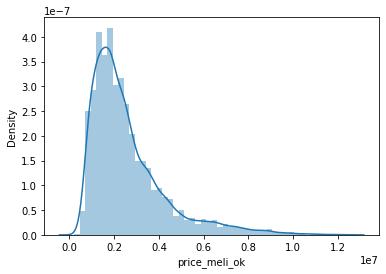

In [92]:
sns.distplot(y_train)

<AxesSubplot:xlabel='price_meli_ok', ylabel='Density'>

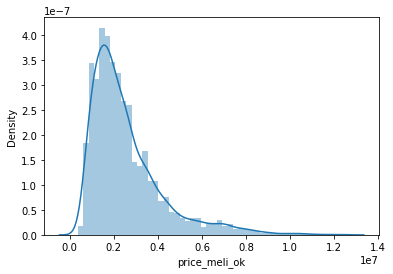

In [93]:
sns.distplot(y_test)

In [94]:
# chequeamos distribuciones de kms en ambos dfs
a = pd.concat([X_train.car_kms.describe(percentiles=[0.005,0.01,0.1,0.25,0.5,0.75,0.9,0.99])
              ,X_test.car_kms.describe(percentiles=[0.005, 0.01,0.1,0.25,0.5,0.75,0.9,0.99])],axis=1)
a.columns = ['kms_train','kms_test']
a

,kms_train,kms_test
count,28545.00,7137.00
mean,104913.88,106440.92
std,61465.29,61766.35
min,115.00,103.00
0.5%,1119.72,1300.00
1%,3500.00,4500.00
10%,29465.60,30000.00
25%,60000.00,60000.00
50%,98000.00,100000.00
75%,141712.00,145000.00


In [95]:
df_train = pd.concat([X_train,y_train],1)
df_test = pd.concat([X_test,y_test],1)

De ahora en más trabajamos solo sobre df_train para evitar data leakage.

In [96]:
del df

### Salvamos los df de train y test

In [97]:
df_train.to_csv('{}df_train_checkpoint_3.pkl'.format(path_save))
df_test.to_csv('{}df_test_checkpoint_3.pkl'.format(path_save))

# Univariado + Bivariado + Cleaning

* Luego volver a correr este bivariado pero sumandole el nivel año a la agregación, luego y hacer una funcion que capee los valores que traspasen los whiskers en cada agrupacion (ej: toyota - hilux - 2020) tanto para km como para precios.
* Usar la version acara en lugarde la de camval
* Mirar los errores en la perfo del modelo, no solo el R2 (la func evaluate que use para airtm)

In [98]:
df_train.columns

Index(['car_year', 'car_kms', 'match_marca_a', 'match_modelo_a', 'match_v1_a',
       'match_v1_c', 'Subseg_a', 'Seg_a', 'price_meli_ok'],
      dtype='object')

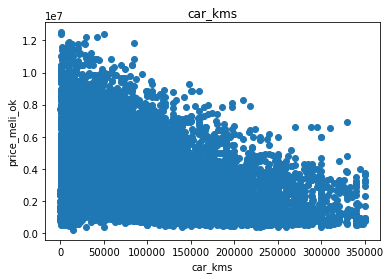

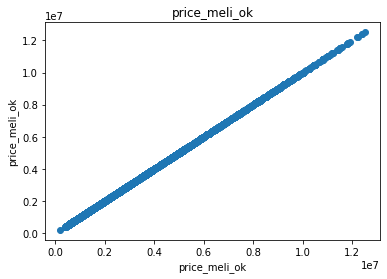

In [99]:
for feature in ['car_kms','price_meli_ok']:
    plt.scatter(df_train[feature],df_train['price_meli_ok'])
    plt.xlabel(feature)
    plt.ylabel('price_meli_ok')
    plt.title(feature)
    plt.show()

In [100]:
mask = df_train.match_marca_a == 'TOYOTA'
data = df_train[mask]
modelos = data.match_modelo_a.unique()
modelos

array(['Camry', 'Yaris', 'Corolla', 'Etios', 'Hilux'], dtype=object)

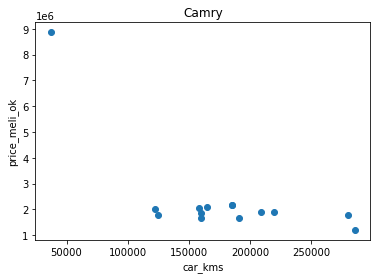

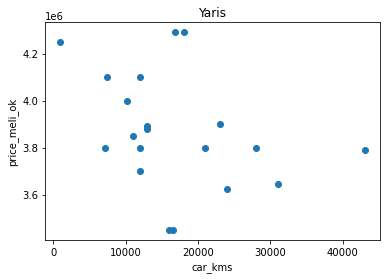

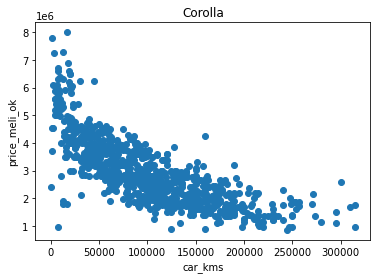

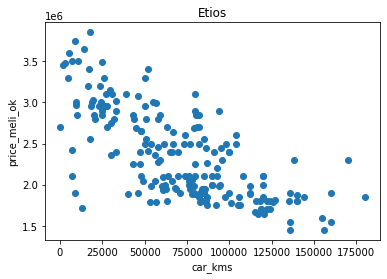

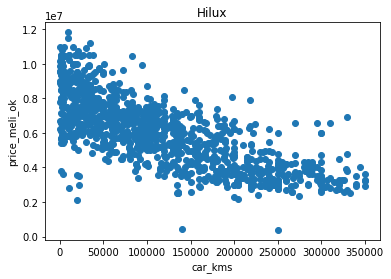

In [101]:
for i in modelos:
    sub_mask = data.match_modelo_a == i
    plt.scatter(data[sub_mask]['car_kms'],data[sub_mask]['price_meli_ok'])
    plt.xlabel('car_kms')
    plt.ylabel('price_meli_ok')
    plt.title(i)
    plt.show()

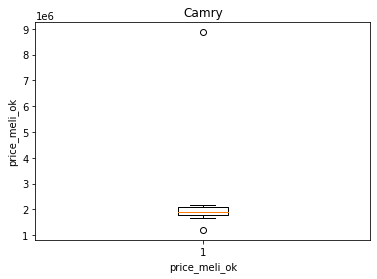

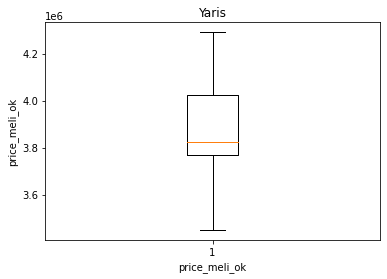

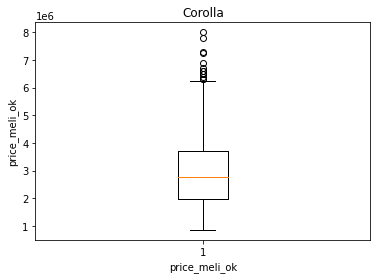

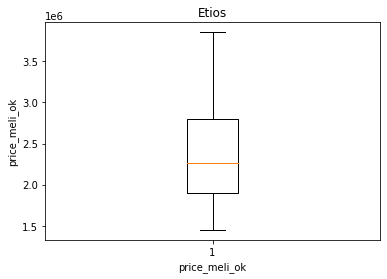

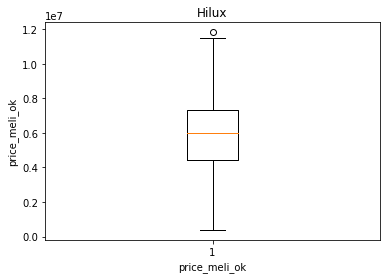

In [102]:
for i in modelos:
    sub_mask = data.match_modelo_a == i
    plt.boxplot(data[sub_mask]['price_meli_ok'])
    plt.xlabel('price_meli_ok')
    plt.ylabel('price_meli_ok')
    plt.title(i)
    plt.show()

Vamos a chequear si los detectamos con la formula q3+1.5*IQR

In [103]:
mask = df_train.match_modelo_a == 'Etios'
data = df_train[mask].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.price_meli_ok>=outl_thresh_superior]))

4150000.0
0


In [104]:
mask = df_train.match_modelo_a == 'Hilux'
data = df_train[mask].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.price_meli_ok>=outl_thresh_superior]))

11625625.0
1


Perfect

*Lo mismo para kms*

In [105]:
mask = df_train.match_marca_a == 'TOYOTA'
data = df_train[mask]
modelos = data.match_modelo_a.unique()
modelos

array(['Camry', 'Yaris', 'Corolla', 'Etios', 'Hilux'], dtype=object)

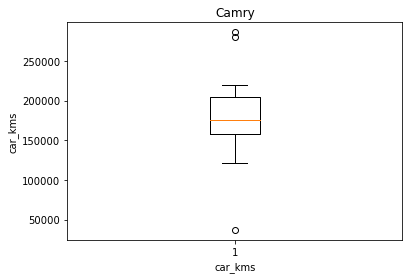

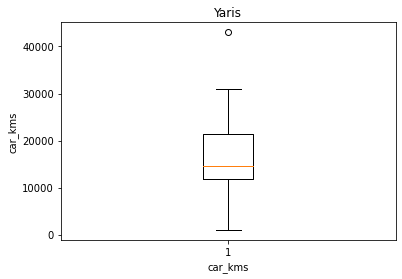

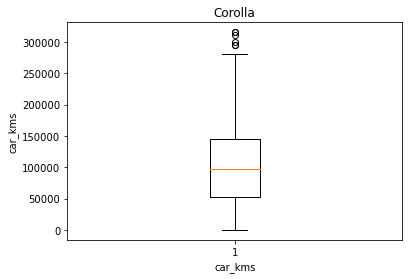

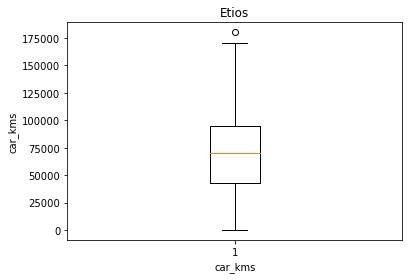

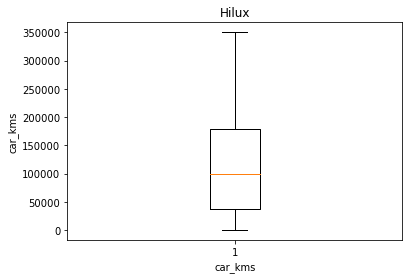

In [106]:
for i in modelos:
    sub_mask = data.match_modelo_a == i
    plt.boxplot(data[sub_mask]['car_kms'])
    plt.xlabel('car_kms')
    plt.ylabel('car_kms')
    plt.title(i)
    plt.show()

In [107]:
mask = df_train.match_modelo_a == 'Etios'
data = df_train[mask].copy()
q1 = data.car_kms.quantile(0.25)
q3 = data.car_kms.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.car_kms>=outl_thresh_superior]))

171553.5
1


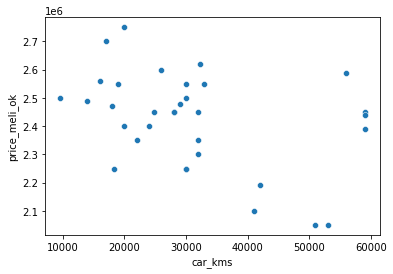

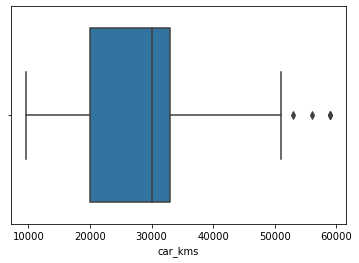

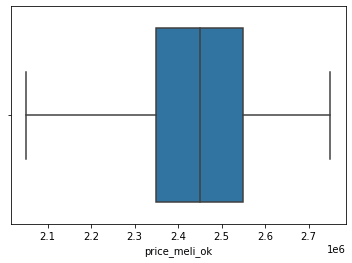

In [108]:
mask1 =df_train.match_marca_a == 'VOLKSWAGEN'
mask2 =df_train.match_modelo_a == 'Gol Trend'
mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()
#df_train[mask1 & mask2 & mask3].groupby('car_year')['price_meli_ok'].mean().plot.bar()
#plt.show()

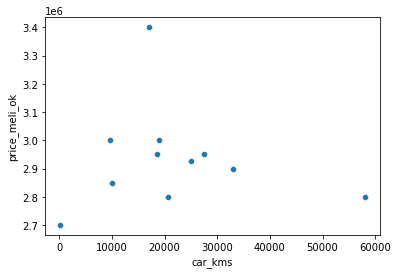

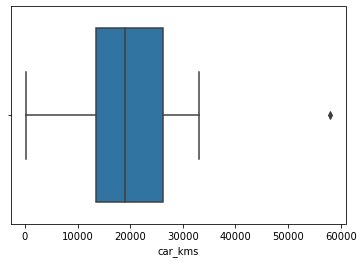

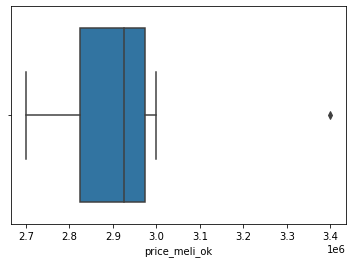

In [109]:
mask1 =df_train.match_marca_a == 'TOYOTA'
mask2 =df_train.match_modelo_a == 'Etios'
mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()
#df_train[mask1 & mask2 & mask3].groupby('car_year')['price_meli_ok'].mean().plot.bar()
#plt.show()

In [110]:
mask1 = df_train.match_modelo_a == 'Etios'
mask2 = df_train.car_year == 2019
data = df_train[mask1 & mask2].copy()
q1 = data.car_kms.quantile(0.25)
q3 = data.car_kms.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.car_kms>=outl_thresh_superior]))

45375.0
1


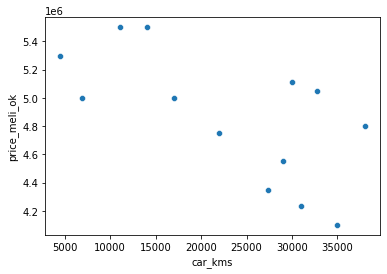

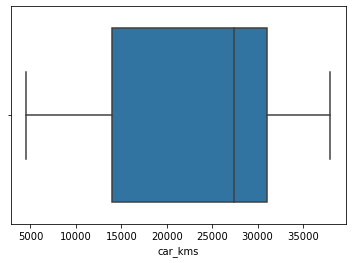

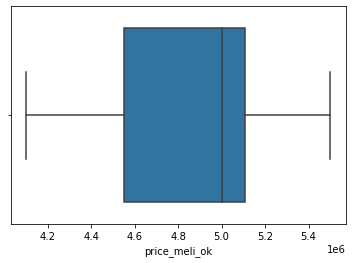

In [111]:
mask1 =df_train.match_marca_a == 'VOLKSWAGEN'
mask2 =df_train.match_modelo_a == 'T-Cross'
#mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2]['car_kms'],df_train[mask1 & mask2]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2]['price_meli_ok'],)
plt.show()

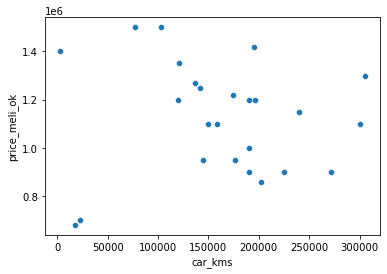

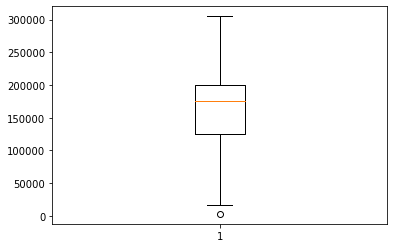

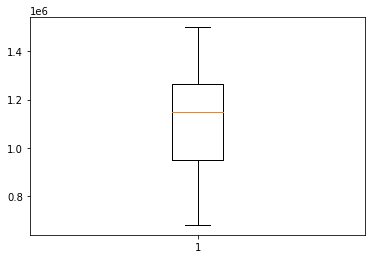

In [112]:
mask1 =df_train.match_marca_a == 'RENAULT'
mask2 =df_train.match_modelo_a == 'Kangoo'
mask3 =df_train.car_year == 2009
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
plt.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
plt.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

Aca podemos chequear el valor extremo de la Kangoo que hace que haya aparecido cuando nos fijamos los registros que quedaban por encima del p99 luego de haber hecho el tratamiento de outliers nº1.

También es interesante observar en el boxplot de kms como sale un outlier inferior: es imposible (o demasiado raro) que una kangoo del 2009 tenga menos de 10.000 kms. Todos estos casos ilogicos los vamos a estar eliminando en esta seccion "Tratamiento de outliers nº2"

In [113]:
mask1 = df_train.match_modelo_a == 'Kangoo'
mask2 = df_train.car_year == 2009
data = df_train[mask1 & mask2].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.price_meli_ok>outl_thresh_superior]))

1737500.0
0


In [114]:
mask1 = df_train.match_modelo_a == 'Kangoo'
mask2 = df_train.car_year == 2009
data = df_train[mask1 & mask2].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_inferior = q1-1.5*IQR
print(outl_thresh_inferior)
print(len(data[data.price_meli_ok<outl_thresh_inferior]))

477500.0
0


---

### *Tratamiento de outliers nº2*
* Es un tratamiento profundo donde buscamos **outliers por contexto** (outliers a nivel de agg marca-modelo-año)
* Notar que se hace despues del Split sobre el train, para evitar data leakage! Es decir: fit_transform sobre train y transform sobre test
* Luego lo aplicaremos sobre test pero con los thresholds de outliers aprendidos en train.

In [115]:
# Dropeamos todos los outliers por contexo: "Tratamiento de outliers nº2"

modelos = sorted(list(df_train.match_modelo_a.unique()))
años = sorted(list(df_train.car_year.unique()))
kms_thresh_outliers = {}
price_thresh_outliers = {}
old_shape = df_train.shape[0]
for m in modelos:
    for a in años:
        # print(f'{m} of {a}') --> solo para chequear que el loop este iterando correctamente (esta OK :)
        
        modelo_año = m + '_' + str(a)
        
        
        # kms
        mask1 = df_train.match_modelo_a == m
        mask2 = df_train.car_year == a
        data = df_train[mask1 & mask2].copy()
        
        q1 = data.car_kms.quantile(0.25)
        q3 = data.car_kms.quantile(0.75)
        IQR = q3 - q1
        outl_thresh_superior = q3+3*IQR
        outl_thresh_inferior = q1-3*IQR
        kms_thresh_outliers[modelo_año] = (outl_thresh_inferior,outl_thresh_superior)
        filt_mask_sup = data.car_kms>kms_thresh_outliers[modelo_año][1]
        filt_mask_inf = data.car_kms<kms_thresh_outliers[modelo_año][0]
        data = data[~(filt_mask_sup | filt_mask_inf)]
        df_train = df_train.loc[~(mask1 & mask2),:]
        df_train = pd.concat([df_train,data],0)
        
        # price
        mask1 = df_train.match_modelo_a == m
        mask2 = df_train.car_year == a
        data = df_train[mask1 & mask2].copy()
        
        q1 = data.price_meli_ok.quantile(0.25)
        q3 = data.price_meli_ok.quantile(0.75)
        IQR = q3 - q1
        outl_thresh_superior = q3+3*IQR
        outl_thresh_inferior = q1-3*IQR
        price_thresh_outliers[modelo_año] = (outl_thresh_inferior,outl_thresh_superior)
        filt_mask_sup = data.price_meli_ok>price_thresh_outliers[modelo_año][1]
        filt_mask_inf = data.price_meli_ok<price_thresh_outliers[modelo_año][0]
        data = data[~(filt_mask_sup | filt_mask_inf)]
        df_train = df_train.loc[~(mask1 & mask2),:]
        df_train = pd.concat([df_train,data],0)

print(f'Hey! {old_shape - df_train.shape[0]} were removed from df_train due to outliers under context')        

Hey! 295 were removed from df_train due to outliers under context


In [116]:
price_thresh_outliers

{'2008_2006': (nan, nan),
 '2008_2007': (nan, nan),
 '2008_2008': (nan, nan),
 '2008_2009': (nan, nan),
 '2008_2010': (nan, nan),
 '2008_2011': (nan, nan),
 '2008_2012': (nan, nan),
 '2008_2013': (nan, nan),
 '2008_2014': (nan, nan),
 '2008_2015': (nan, nan),
 '2008_2016': (1525000.0, 3800000.0),
 '2008_2017': (1550000.0, 4350000.0),
 '2008_2018': (1400000.0, 4900000.0),
 '2008_2019': (2400000.0, 4850000.0),
 '2008_2020': (1025000.0, 6975000.0),
 '2008_2021': (2545000.0, 6552500.0),
 '206_2006': (420000.0, 1260000.0),
 '206_2007': (380000.0, 1325000.0),
 '206_2008': (510000.0, 1280000.0),
 '206_2009': (300000.0, 1367500.0),
 '206_2010': (340000.0, 1530000.0),
 '206_2011': (374625.0, 1600500.0),
 '206_2012': (550000.0, 1600000.0),
 '206_2013': (nan, nan),
 '206_2014': (nan, nan),
 '206_2015': (nan, nan),
 '206_2016': (nan, nan),
 '206_2017': (nan, nan),
 '206_2018': (nan, nan),
 '206_2019': (nan, nan),
 '206_2020': (nan, nan),
 '206_2021': (nan, nan),
 '207_2006': (nan, nan),
 '207_2007

**Chequeos**

In [117]:
df_train.shape

(28250, 9)

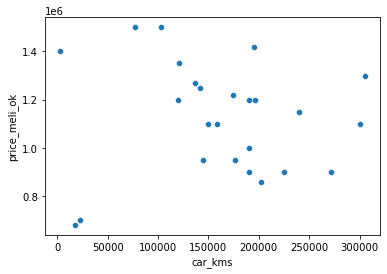

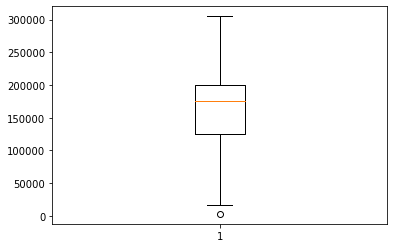

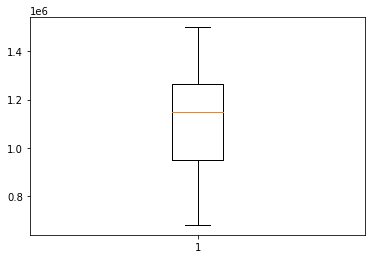

In [118]:
mask1 =df_train.match_marca_a == 'RENAULT'
mask2 =df_train.match_modelo_a == 'Kangoo'
mask3 =df_train.car_year == 2009

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
plt.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
plt.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

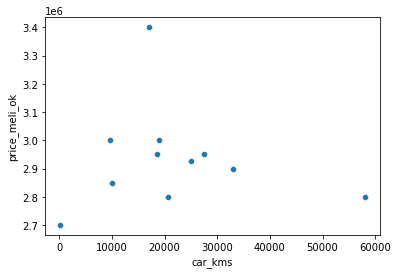

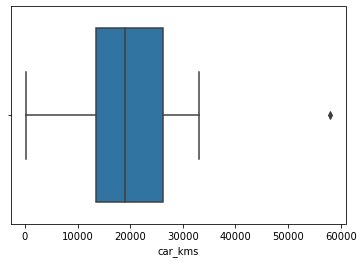

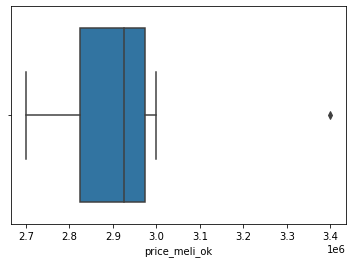

In [119]:
mask1 =df_train.match_marca_a == 'TOYOTA'
mask2 =df_train.match_modelo_a == 'Etios'
mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

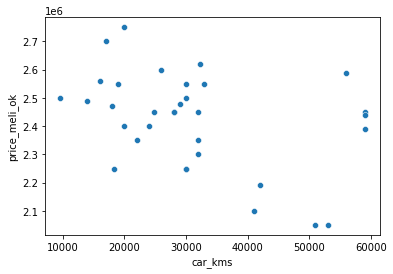

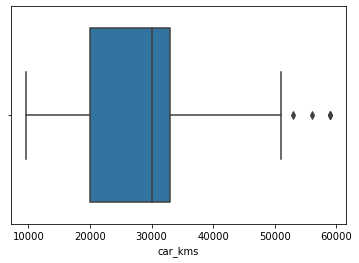

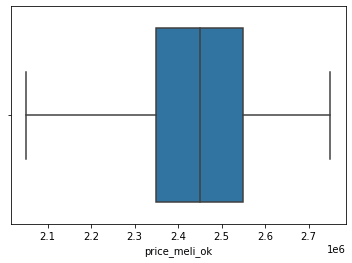

In [120]:
mask1 =df_train.match_marca_a == 'VOLKSWAGEN'
mask2 =df_train.match_modelo_a == 'Gol Trend'
mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

In [121]:
mask1 = df_train.match_modelo_a == 'Gol Trend'
mask2 = df_train.car_year == 2019
data = df_train[mask1 & mask2].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.price_meli_ok>outl_thresh_superior]))

2850000.0
0


Si bien es cierto que siguen apareciendo outliers, esto es normal debido a que con el tratamiento que hicimos la distribucion cambia y es logico que ahora un valor que antes no se consideraba outliers si se considere. Lo bueno es que ahora estos outliers ya no son tan extremos e irriorios.

In [122]:
price_thresh_outliers

{'2008_2006': (nan, nan),
 '2008_2007': (nan, nan),
 '2008_2008': (nan, nan),
 '2008_2009': (nan, nan),
 '2008_2010': (nan, nan),
 '2008_2011': (nan, nan),
 '2008_2012': (nan, nan),
 '2008_2013': (nan, nan),
 '2008_2014': (nan, nan),
 '2008_2015': (nan, nan),
 '2008_2016': (1525000.0, 3800000.0),
 '2008_2017': (1550000.0, 4350000.0),
 '2008_2018': (1400000.0, 4900000.0),
 '2008_2019': (2400000.0, 4850000.0),
 '2008_2020': (1025000.0, 6975000.0),
 '2008_2021': (2545000.0, 6552500.0),
 '206_2006': (420000.0, 1260000.0),
 '206_2007': (380000.0, 1325000.0),
 '206_2008': (510000.0, 1280000.0),
 '206_2009': (300000.0, 1367500.0),
 '206_2010': (340000.0, 1530000.0),
 '206_2011': (374625.0, 1600500.0),
 '206_2012': (550000.0, 1600000.0),
 '206_2013': (nan, nan),
 '206_2014': (nan, nan),
 '206_2015': (nan, nan),
 '206_2016': (nan, nan),
 '206_2017': (nan, nan),
 '206_2018': (nan, nan),
 '206_2019': (nan, nan),
 '206_2020': (nan, nan),
 '206_2021': (nan, nan),
 '207_2006': (nan, nan),
 '207_2007

In [123]:
# Guardamos los diccionarios con la info de outiers thresholds en formato json
with open('{}kms_thresh_outliers.json'.format(path_save), 'w') as outfile:
    json.dump(kms_thresh_outliers, outfile)

with open('{}price_thresh_outliers.json'.format(path_save), 'w') as outfile:
    json.dump(price_thresh_outliers, outfile)

Notesé que en muchos casos nos quedan "nan", eso es porque aveces no tenemos ningun registro de un marca-modelo para un cierto año en particular (ej: talvez no se fabrico ese modelo durante ese año o cosas así). Por lo único que tendremos que tener cuidado es cuando apliquemos este cleaning sobre test, vamos a tener que poner un "if" que haga un "pass" en caso de que los thresh seas "nan"

In [124]:
df_train.to_csv('{}df_train_checkpoint_4.pkl'.format(path_save)) # este es el df_train final!
# el test sigue igual

# Applying data cleaning in the test set

In [125]:
df_train_ok = pd.read_csv('{}df_train_checkpoint_4.pkl'.format(path_save))

In [126]:
df_test = pd.read_csv('{}df_test_checkpoint_3.pkl'.format(path_save))

In [127]:
print(df_train_ok.shape)
print(df_test.shape)

(28250, 10)
(7137, 10)


In [128]:
# Aplicamos el data cleaning aprendido en train sobre el set de test para usarlo en la evaluacion
df_test_ok = data_processing_1(df_test,path_save)

Hey! 216 were removed from df due to outliers under context


In [129]:
df_test_ok.shape

(6921, 10)

In [130]:
df_test_ok.to_csv('{}df_test_checkpoint_4.pkl'.format(path_save)) # este es el df_test final!

In [131]:
df_test_ok = pd.read_csv('{}df_test_checkpoint_4.pkl'.format(path_save))
df_test_ok.shape

(6921, 11)

# Modelling

In [132]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','Subseg_a', 'Seg_a']

In [133]:
# Volvemos a separar en X e y
X_train = df_train_ok[model_features]
y_train = df_train_ok.price_meli_ok

X_test = df_test_ok[model_features]
y_test = df_test_ok.price_meli_ok

## Modelo Baseline

In [134]:
X_train.columns

Index(['car_year', 'car_kms', 'match_marca_a', 'match_modelo_a', 'match_v1_a',
       'Subseg_a', 'Seg_a'],
      dtype='object')

In [135]:
# Recordar agregar esto en la funcion de procesamiento para la simulacion

# Cuando hice el tratamiento de 1111 y 99999 había pasado la feature de kms a int. Volvemos a pasar a float por el catboost
X_train['car_kms'] = X_train['car_kms'].astype('float')
X_test['car_kms'] = X_test['car_kms'].astype('float')

# probamos tanto usando year como int y como float y la perfo del modelo dio apenas mejor con year en float
X_train['car_year'] = X_train['car_year'].astype('float')
X_test['car_year'] = X_test['car_year'].astype('float')

In [136]:
X_train.dtypes

car_year          float64
car_kms           float64
match_marca_a      object
match_modelo_a     object
match_v1_a         object
Subseg_a           object
Seg_a              object
dtype: object

In [137]:
np.where(X_train[model_features].dtypes != np.float)[0]

array([2, 3, 4, 5, 6])

In [138]:
model=CatBoostRegressor(loss_function='RMSE',logging_level="Silent")
categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

Train set evaluation:
_____________________________________
MAE: 198309.89324914408
MAPE: 8.502377590635465
MEDAPE: 6.4243546461028656
MSE: 88365335455.12228
RMSE: 297263.0744897897
R2 Square 0.9689608885726668
__________________________________
Test set evaluation:
_____________________________________
MAE: 204620.8359874006
MAPE: 8.780429284430877
MEDAPE: 6.536368869518834
MSE: 101865250788.28992
RMSE: 319163.36066079064
R2 Square 0.9621569235476245
__________________________________


In [139]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,car_year,28.54
1,Subseg_a,25.18
2,match_marca_a,16.67
3,match_modelo_a,10.72
4,car_kms,6.74
5,match_v1_a,6.66
6,Seg_a,5.48


In [140]:
# Save del modelo fiteado

path_model_save = '../model/'

import pickle
with open('{}model_catboost_v4.pickle'.format(path_model_save), 'wb') as f:
    pickle.dump(model, f)

## Rangos para la prediccion

###  a) en base a castigar/premiar kms

In [21]:
# backup copies
X_test_v2 = X_test.copy()
y_test_v2 = y_test.copy()
# creamos un id
X_test_v2 = X_test_v2.reset_index().rename(columns={'index':'ID'})
y_test_v2 = y_test_v2.reset_index().rename(columns={'index':'ID'})

In [22]:
X_test_v2.head()

,ID,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a
0,0,2014.00,150000.00,VOLKSWAGEN,Passat,Variant 2.0 TSi Luxury DSG Techo (211cv) (L11),Gama Grandes Sedan,Gama Grandes
1,1,2017.00,48059.00,CHEVROLET,S-10,2.8 TD DLX 4x4,Pickups Medianas-Grandes,Livianos
2,2,2011.00,139000.00,JEEP,Grand Cherokee,Limited 3.6 V6 AT (286hp) (L11),SUV 4X4,SUV
3,3,2011.00,198000.00,VOLKSWAGEN,Golf,1.6 Conceptline / Comfortline (100cv) (L07),Gama Medianos Hatchback,Gama Medianos
4,4,2016.00,53000.00,BMW,X5,3.0 Executive,SUV Premium,SUV


In [24]:
# Prueba con un caso puntual -> OK
cols = X_test_v2.columns.tolist()
X_test_v3 = pd.DataFrame(columns=cols)

mask = X_test_v2.ID == 3
castig_val = (X_test_v2[mask]['car_kms'].item())*0.8
prem_val = (X_test_v2[mask]['car_kms'].item())*1.2
orig_ser = X_test_v2[mask]
castig_ser = orig_ser.copy()
castig_ser['car_kms'] = castig_val
prem_ser = orig_ser.copy()
prem_ser['car_kms'] = prem_val
X_test_v3 = pd.concat([X_test_v3, castig_ser, prem_ser])
X_test_v3

,ID,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a
3,3,2011.00,158400.00,VOLKSWAGEN,Golf,1.6 Conceptline / Comfortline (100cv) (L07),Gama Medianos Hatchback,Gama Medianos
3,3,2011.00,237600.00,VOLKSWAGEN,Golf,1.6 Conceptline / Comfortline (100cv) (L07),Gama Medianos Hatchback,Gama Medianos


In [25]:
# Creamos los registros con km castigado/premiado
cols = X_test_v2.columns.tolist()
X_test_v3 = pd.DataFrame(columns=cols)
for idi in list(X_test_v2.ID):
    mask = X_test_v2.ID == idi
    castig_val = (X_test_v2[mask]['car_kms'].item())*0.8
    prem_val = (X_test_v2[mask]['car_kms'].item())*1.2
    orig_ser = X_test_v2[mask]
    castig_ser = orig_ser.copy()
    castig_ser['car_kms'] = castig_val
    prem_ser = orig_ser.copy()
    prem_ser['car_kms'] = prem_val
    X_test_v3 = pd.concat([X_test_v3, castig_ser, prem_ser])

In [26]:
X_test_v3.head(10)

,ID,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a
0,0,2014.00,120000.00,VOLKSWAGEN,Passat,Variant 2.0 TSi Luxury DSG Techo (211cv) (L11),Gama Grandes Sedan,Gama Grandes
0,0,2014.00,180000.00,VOLKSWAGEN,Passat,Variant 2.0 TSi Luxury DSG Techo (211cv) (L11),Gama Grandes Sedan,Gama Grandes
1,1,2017.00,38447.20,CHEVROLET,S-10,2.8 TD DLX 4x4,Pickups Medianas-Grandes,Livianos
1,1,2017.00,57670.80,CHEVROLET,S-10,2.8 TD DLX 4x4,Pickups Medianas-Grandes,Livianos
2,2,2011.00,111200.00,JEEP,Grand Cherokee,Limited 3.6 V6 AT (286hp) (L11),SUV 4X4,SUV
2,2,2011.00,166800.00,JEEP,Grand Cherokee,Limited 3.6 V6 AT (286hp) (L11),SUV 4X4,SUV
3,3,2011.00,158400.00,VOLKSWAGEN,Golf,1.6 Conceptline / Comfortline (100cv) (L07),Gama Medianos Hatchback,Gama Medianos
3,3,2011.00,237600.00,VOLKSWAGEN,Golf,1.6 Conceptline / Comfortline (100cv) (L07),Gama Medianos Hatchback,Gama Medianos
4,4,2016.00,42400.00,BMW,X5,3.0 Executive,SUV Premium,SUV
4,4,2016.00,63600.00,BMW,X5,3.0 Executive,SUV Premium,SUV


In [27]:
test_pred_ranges = model.predict(X_test_v3.drop('ID',1))
X_test_v3['pred'] = test_pred_ranges

In [28]:
# el rango que se genera es demasiado pequeño, no nos sirve para nuestros fines
# el impacto que tiene kms no hace tanto la diferencia.
X_test_v3.merge(y_test_v2, on = 'ID').head(10)

,ID,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,pred,price_meli_ok
0,0,2014.00,120000.00,VOLKSWAGEN,Passat,Variant 2.0 TSi Luxury DSG Techo (211cv) (L11),Gama Grandes Sedan,Gama Grandes,2869448.64,2842800.00
1,0,2014.00,180000.00,VOLKSWAGEN,Passat,Variant 2.0 TSi Luxury DSG Techo (211cv) (L11),Gama Grandes Sedan,Gama Grandes,2700911.36,2842800.00
2,1,2017.00,38447.20,CHEVROLET,S-10,2.8 TD DLX 4x4,Pickups Medianas-Grandes,Livianos,4941679.39,6000000.00
3,1,2017.00,57670.80,CHEVROLET,S-10,2.8 TD DLX 4x4,Pickups Medianas-Grandes,Livianos,4844254.17,6000000.00
4,2,2011.00,111200.00,JEEP,Grand Cherokee,Limited 3.6 V6 AT (286hp) (L11),SUV 4X4,SUV,4014354.42,4326000.00
5,2,2011.00,166800.00,JEEP,Grand Cherokee,Limited 3.6 V6 AT (286hp) (L11),SUV 4X4,SUV,3683293.25,4326000.00
6,3,2011.00,158400.00,VOLKSWAGEN,Golf,1.6 Conceptline / Comfortline (100cv) (L07),Gama Medianos Hatchback,Gama Medianos,2316176.55,1153600.00
7,3,2011.00,237600.00,VOLKSWAGEN,Golf,1.6 Conceptline / Comfortline (100cv) (L07),Gama Medianos Hatchback,Gama Medianos,2102286.84,1153600.00
8,4,2016.00,42400.00,BMW,X5,3.0 Executive,SUV Premium,SUV,8762736.07,12772000.00
9,4,2016.00,63600.00,BMW,X5,3.0 Executive,SUV Premium,SUV,8129900.90,12772000.00


Vemos que el rango que se genera es demasiado acotado como para captar el target real. DESCARTAMOS ESTE APROACH

###  a) directamente sobre el output

In [25]:
# backup copies
X_test_v2 = X_test.copy()
y_test_v2 = y_test.copy()
# creamos un id
X_test_v2 = X_test_v2.reset_index().rename(columns={'index':'ID'})
y_test_v2 = y_test_v2.reset_index().rename(columns={'index':'ID'})

In [29]:
X_test_v2_subsamp = X_test_v2.iloc[0:5,:]
y_test_v2_subsam = y_test_v2.iloc[0:5,:]
test_pred = model.predict(X_test_v2_subsamp.drop('ID',1))

In [31]:
output = pd.DataFrame({'pred':test_pred, 'true': y_test_v2_subsam.price_meli_ok})
output

,pred,true
0,2773298.37,2842800.00
1,4947631.86,6000000.00
2,3863878.37,4326000.00
3,2216029.30,1153600.00
4,8504374.88,12772000.00


In [33]:
output['pred+10perc'] = output['pred']*1.1
output['pred-10perc'] = output['pred']*0.9
output = output[['pred','pred-10perc','pred+10perc','true']]
output

,pred,pred-10perc,pred+10perc,true
0,2773298.37,2495968.54,3050628.21,2842800.00
1,4947631.86,4452868.67,5442395.04,6000000.00
2,3863878.37,3477490.53,4250266.21,4326000.00
3,2216029.30,1994426.37,2437632.23,1153600.00
4,8504374.88,7653937.39,9354812.37,12772000.00


In [43]:
# ""Accuracy""
#and 
output['check'] = np.where((output['true'] >= output['pred-10perc']) & (output['true']<=output['pred+10perc']),1,0)
output

,pred,pred-10perc,pred+10perc,true,check
0,2773298.37,2495968.54,3050628.21,2842800.00,1
1,4947631.86,4452868.67,5442395.04,6000000.00,0
2,3863878.37,3477490.53,4250266.21,4326000.00,0
3,2216029.30,1994426.37,2437632.23,1153600.00,0
4,8504374.88,7653937.39,9354812.37,12772000.00,0


In [ ]:
col         = 'true'
conditions  = [(output[col] >= output['pred-10perc']) & (output[col]<=output['pred+10perc'])]
choices     = [ "high", 'medium', 'low' ]
    
df2["energy_class"] = np.select(conditions, choices, default=np.nan)

In [29]:
# seguir con el listado de abajo (prioridad: procesamiento para la simul y pasarle todo el pack denuevo a favio)

In [ ]:
# Prueba con un caso puntual -> OK
cols = X_test_v2.columns.tolist()
X_test_v3 = pd.DataFrame(columns=cols)

mask = X_test_v2.ID == 3
castig_val = (X_test_v2[mask]['car_kms'].item())*0.8
prem_val = (X_test_v2[mask]['car_kms'].item())*1.2
orig_ser = X_test_v2[mask]
castig_ser = orig_ser.copy()
castig_ser['car_kms'] = castig_val
prem_ser = orig_ser.copy()
prem_ser['car_kms'] = prem_val
X_test_v3 = pd.concat([X_test_v3, castig_ser, prem_ser])
X_test_v3

VOLVER A CORRER LA NB DE TRAIN CON DATA NUEVA POR DOS MOTIVOS:
    1) POR LE VIENE BIEN AL ALGORTIMO PARA LA PREDICCION
    2) PORQUE SE CORRIGIO LO DEL AÑO 2008 Y HAY QUE SUMAR A LOS JSON QUE CONTIENEN LA INFO DE OUTLIERS POR CONTEXTO, LA INFO DE LOS 2008. PARA SALIR DEL PASO LE HICE UN "PARCHE" A FUNC_COTIZADOR.PY

* Revision del sheets: OK
    - ver si los autos que predecimos mal son siempre los mismos o aveces los predecimos bien.
    - revisar si en la simulacion estan metiendosé casos de versiones que no se usaron para train --> esto era así debido a que lo de los grupos lo había hecho a nivel marca-modelo, ahora le agregue el nivel de version y esto se tendría que coregir... esperemos a ver los resultados de las simul
* Ajustar procesamiento. OK
    * Hacer la limpieza de categorias a nivel marca-modelo-version, para excluir tanto del entrenamiento como de las simulaciones las versiones con bajo vol. (esto podría generar que la variable version pase a tener mayor importance) --> dicho y hecho, así fue.<br>
de la mano con esto, calcular que % de versiones estan quedando afuera en cada marca-modelo (o a nivel general, validarlo con Pato)
* Si no funciona lo del rango en base a kms hacerlo sobre el output directamente (usaremos un 10% dado que el MAPE es 9%)
* Accucary en base al rango.
* Ajustar procesamiento en la simulacion
* Hacer la matriz de confu que hice para airtm


* Backlog:
    * Hacer procsamiento de la version usando lo de (L11) que sería 2011, en ese caso fijarnos que eso coincida con el con car_year, y sino coincide eliminar el registro (ver el chat con Emi) y luego re-entrenar.
    * Re-entrenar con un nuevo make_data más actualizado y actualizando el tipo de cambio
    * Optimizar hiperparametros a ver si logramos mejorar el mape (hacerlo desde la nube rappi) -- si con grid search no mejoramos, probar optuna

Cotizador

- cambios en el entrenamiento para el v4

	- score matcheo >= 80  (POST SPLIT)
	- limpieza de categorías a nivel marca-modelo-version (POST SPLIT)
	- solo incluimos grupos 1, 2 y 3 para el algoritmo (PRE SPLIT)
	- usamos 3 en lugar de 1.5 para el tratamiento de outliers por contexto (POST SPLIT)

- faltaría sumar estas modificaciones en el processing en la simulacion

## Optimización de Hiperparametros

In [157]:
# # A)
# parameters = {'depth'         : [6,8,10],
#               'learning_rate' : [0.01, 0.05, 0.1, 0.15],
#               'iterations'    : [100, 120, 150, 200, 250],
#               'l2_leaf_reg': [0.2, 0.5, 1, 3]
#              }


# #model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

# model=CatBoostRegressor(loss_function='RMSE',logging_level="Silent")
# grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs= -1, scoring='r2')
# categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
# grid.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))    

# # Results from Grid Search
# print("\n========================================================")
# print(" Results from Grid Search " )
# print("========================================================")    

# print("\n The best estimator across ALL searched params:\n",
#       grid.best_estimator_)

# print("\n The best score across ALL searched params:\n",
#       grid.best_score_)

# print("\n The best parameters across ALL searched params:\n",
#       grid.best_params_)

# print("\n ========================================================")

Mediante la optimizacion de hiperparametros con GridSearch no mejoramos la performance. Tener en cuenta que el baseline de Catboost se caracteriza por ser bastante optimo. De todas formas más adelante podríamos probar Optuna a modo de mejora.

Por lo tanto, nuestro mejor modelo lo obtenemos con el baseline de CatBoost.

## Evaluación

In [21]:
# los metodos que use en el desafio de airtm

In [159]:
# pending

## Validacion OOT

In [55]:
# pending

Mejoras:
* Sumar la feature de discontinuados (Favio)
* Features de InfoAutos (Cande se esta encargando de eso pero todavía no las tenemos)
* Mejor preprocesing a la feature version (ej: standarizar los valores para los casos de nula volatilidad en el precio)